In [29]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array



In [30]:
import tensorflow as tf
import os

def load_image_dataset(img_dir, img_size=(64, 64), batch_size=32):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        img_dir,
        label_mode=None,  # No labels, only images
        image_size=img_size,
        batch_size=batch_size
    )
    
    # Normalize images to [0, 1] range
    dataset = dataset.map(lambda x: x / 255.0)
    dataset = dataset.shuffle(1000).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Set paths to local dataset
data_dir = "Birds"  # Change this to your actual path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Load datasets
train_dataset = load_image_dataset(train_dir)
test_dataset = load_image_dataset(test_dir)

# Verify dataset loading
for batch in train_dataset.take(1):
    print(f"Batch shape: {batch.shape}")  # Expected: (batch_size, 64, 64, 3)


Found 2750 files belonging to 1 classes.
Found 250 files belonging to 1 classes.
Batch shape: (32, 64, 64, 3)


In [31]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model



In [32]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model



In [33]:
generator = build_generator()
discriminator = build_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



In [34]:
def train_step(images):
    noise = tf.random.normal([images.shape[0], 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [35]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch) 
        print(f'Epoch {epoch+1} completed')

train(train_dataset, epochs=70)


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epoch 47 completed
Epoch 48 completed
Epoch 49 completed
Epoch 50 completed
Epoch 51 completed
Epoch 52 completed
Epoch 53 completed
Ep

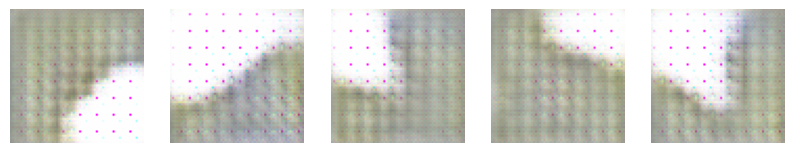

In [39]:
def generate_and_save_images(generator, num_images=5):
    noise = tf.random.normal([num_images, 100])
    generated_images = generator(noise, training=False)
    fig, ax = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        ax[i].imshow((generated_images[i] + 1) / 2)
        ax[i].axis('off')
    plt.show()


generate_and_save_images(generator, num_images=5)
